In [12]:
#All libraries import here
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import json
import pandas as pd
import datetime as dt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ray
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, normaltest, jarque_bera
from hurst import compute_Hc
from functools import partial
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import normaltest

## Data loading

In [14]:
df = pd.read_csv('BTCUSDT_daily.csv')
df.head(14)

,Date,Open,High,Low,Close,Volume
0,2018-01-01 11:00:00,13715.65,13818.55,12750.00,13380.00,8609.915844
1,2018-01-02 11:00:00,13382.16,15473.49,12890.02,14675.11,20078.092111
2,2018-01-03 11:00:00,14690.00,15307.56,14150.00,14919.51,15905.667639
3,2018-01-04 11:00:00,14919.51,15280.00,13918.04,15059.54,21329.649574
4,2018-01-05 11:00:00,15059.56,17176.24,14600.00,16960.39,23251.491125
5,2018-01-06 11:00:00,16960.39,17143.13,16011.21,17069.79,18571.457508
6,2018-01-07 11:00:00,17069.79,17099.96,15610.00,16150.03,12493.125558
7,2018-01-08 11:00:00,16218.85,16322.30,12812.00,14902.54,26600.609912
8,2018-01-09 11:00:00,14902.54,15500.00,14011.05,14400.00,14315.004253
9,2018-01-10 11:00:00,14401.00,14955.66,13131.31,14907.09,17411.001655


In [16]:
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# ---------- 1. Calculate Technical Indicators ----------

# Log Returns
df_copy['LogReturns'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

# Parkinson Volatility
df_copy['Volatility'] = (np.log(df_copy['High']) - np.log(df_copy['Low'])) ** 2 / (4 * np.log(2))

# back 14-day SMA and EMA
df_copy['SMA_14'] = df_copy['Close'].rolling(window=14).mean()
# 14-day RSI
delta = df_copy['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_copy['RSI_14'] = 100 - (100 / (1 + rs))

# OBV
obv = [0]
for i in range(1, len(df_copy)):
    if df_copy['Close'].iloc[i] > df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_copy['Volume'].iloc[i])
    elif df_copy['Close'].iloc[i] < df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_copy['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_copy['OBV'] = obv

# ATR (14-day)
high_low = df_copy['High'] - df_copy['Low']
high_close = np.abs(df_copy['High'] - df_copy['Close'].shift(1))
low_close = np.abs(df_copy['Low'] - df_copy['Close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_copy['ATR_14'] = tr.rolling(window=14).mean()

# Drop rows with NaNs from rolling windows
df_copy = df_copy.dropna()

# ---------- 2. Normalize All 8 Features ----------
features_to_scale = ['LogReturns', 'Volume', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']
scaler = MinMaxScaler(feature_range=(0, 1))

for feature in features_to_scale:
    df_copy.loc[:, f'{feature}_Norm'] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1)).flatten()

# ---------- 3. Create Sequences Using the Normalised Features ----------
def create_multifeature_sequences(data, feature_columns, seq_length=3):
    # Pre-allocate arrays
    n_samples = len(data) - seq_length
    n_features = len(feature_columns)
    X = np.zeros((n_samples, seq_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    for i in range(n_samples):
        # Build the sequence for each sample
        for j in range(seq_length):
            X[i, j, :] = data.iloc[i + j][feature_columns].values
        # Target is the next raw LogReturns value
        y[i] = data.iloc[i + seq_length]['LogReturns']
    
    return X, y

# Use all 8 normalized features
feature_columns = ['LogReturns_Norm', 'Volume_Norm', 'Volatility_Norm'
                   ,'SMA_14_Norm'
                   #, 'EMA_14_Norm'
                   , 'RSI_14_Norm'
                   , 'OBV_Norm'
                   , 'ATR_14_Norm'
                  ]
X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)


In [17]:
df_copy

,Date,Open,High,Low,Close,Volume,LogReturns,Volatility,SMA_14,RSI_14,OBV,ATR_14,LogReturns_Norm,Volume_Norm,Volatility_Norm,SMA_14_Norm,RSI_14_Norm,OBV_Norm,ATR_14_Norm
14,2018-01-15 11:00:00,13477.98,14249.99,13147.79,13539.93,14652.094705,0.004808,0.002337,14803.407857,50.775896,55856.767179,1860.680000,0.745042,0.017583,0.018501,0.113630,0.484936,0.475056,0.294187
15,2018-01-16 11:00:00,13500.00,13542.93,9035.00,10900.00,63401.169175,-0.216880,0.059089,14533.757143,33.799160,-7544.401996,1998.141429,0.419535,0.081777,0.468509,0.110938,0.305204,0.468014,0.316867
16,2018-01-17 11:00:00,10899.99,11680.99,9037.94,10988.79,72331.796646,0.008113,0.023735,14252.991429,32.903015,64787.394650,2104.247857,0.749895,0.093537,0.188175,0.108135,0.295717,0.476048,0.334373
17,2018-01-18 11:00:00,10972.59,11878.82,10435.33,10961.97,48464.434937,-0.002444,0.006054,13960.307857,32.000018,16322.959713,2110.071429,0.734394,0.062108,0.047973,0.105212,0.286157,0.470665,0.335334
18,2018-01-19 11:00:00,10960.00,11795.00,10360.00,11474.98,34129.375421,0.045737,0.006069,13568.492857,22.557335,50452.335134,2028.554286,0.805138,0.043231,0.048095,0.101300,0.186188,0.474456,0.321884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,2025-03-27 11:00:00,86909.17,87756.39,85800.00,87232.01,17098.038970,0.003708,0.000183,85123.903571,65.745032,-814330.499400,2634.332857,0.743427,0.020804,0.001421,0.815742,0.643414,0.378403,0.421831
2643,2025-03-28 11:00:00,87232.01,87515.67,83585.00,84424.38,27182.731690,-0.032715,0.000762,85155.416429,51.139238,-841513.231090,2594.318571,0.689946,0.034083,0.006007,0.816056,0.488783,0.375384,0.415229
2644,2025-03-29 11:00:00,84424.38,84624.73,81644.81,82648.54,11696.398640,-0.021259,0.000464,85034.709286,45.934523,-853209.629730,2731.578571,0.706767,0.013691,0.003642,0.814851,0.433681,0.374084,0.437875
2645,2025-03-30 11:00:00,82648.53,83534.64,81565.00,82389.99,9864.495080,-0.003133,0.000205,85021.527857,49.521376,-863074.124810,2648.272857,0.733382,0.011278,0.001595,0.814720,0.471655,0.372989,0.424131


# Modelling

Our model uses a loss function based on the asymmetric Laplace distribution for quantile regression. While traditional quantile regression uses the "pinball" or "check" loss, our approach frames the problem in a probabilistic context.

### Standard Quantile Regression Loss

The standard quantile regression loss (pinball loss) for a quantile level τ is:

$$\rho_\tau(e) = \begin{cases}
\tau \cdot e, & \text{if } e \geq 0 \\
(1-\tau) \cdot (-e), & \text{if } e < 0
\end{cases}$$

where $e = y - \mu$ is the prediction error.

### Our Approach: Asymmetric Laplace Distribution

We extend this by using the negative log-likelihood (NLL) of the asymmetric Laplace distribution. This distribution has the convenient property that its maximum likelihood estimator corresponds exactly to the quantile regression estimator.

The loss function we implement is:

$$\mathcal{L}(y, \mu) = -\log(\tau(1-\tau)) + \log(\sigma) + \frac{\rho_\tau(e)}{\sigma}$$

where:
- $\mu$ is our model's predicted value
- $\sigma$ is the scale parameter (fixed to 1.0)
- $\tau$ is the desired quantile level
- $\rho_\tau$ is the standard quantile check function

By setting $\sigma = 1.0$, we use a fixed scale parameter, which simplifies the model. The key advantage of this formulation is that it provides a proper probabilistic interpretation of quantile regression, allowing for uncertainty quantification while maintaining the same point estimates as standard quantile regression.


Using your financial data with X_all.shape: (2630, 3, 7), y_all.shape: (2630,)
Starting quantile regression training...

Training model for 2.5% quantile
Early stopping at epoch 60
Test NLL: 3.7166

Training model for 5.0% quantile
Early stopping at epoch 60
Test NLL: 3.0507

Training model for 25.0% quantile
Early stopping at epoch 72
Test NLL: 1.6825

Training model for 50.0% quantile
Early stopping at epoch 64
Test NLL: 1.3969

Training model for 75.0% quantile
Early stopping at epoch 56
Test NLL: 1.6826

Training model for 95.0% quantile
Early stopping at epoch 96
Test NLL: 3.0504

Training model for 97.5% quantile
Early stopping at epoch 59
Test NLL: 3.7162

Results Comparison:
Quantile  Pinball Loss  Empirical Tau     RMSE      MAE
    2.5%      0.002439       0.000000 0.102055 0.097574
    5.0%      0.003645       0.010101 0.076512 0.071465
   25.0%      0.008566       0.166667 0.035665 0.028489
   50.0%      0.010568       0.373737 0.028478 0.021135
   75.0%      0.008611      

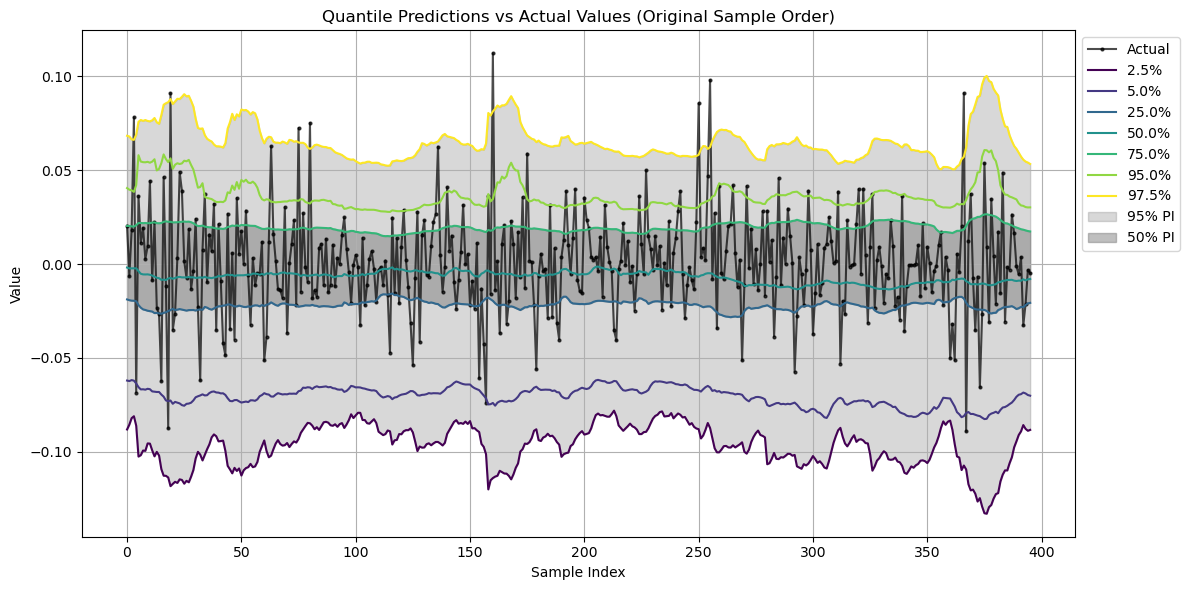

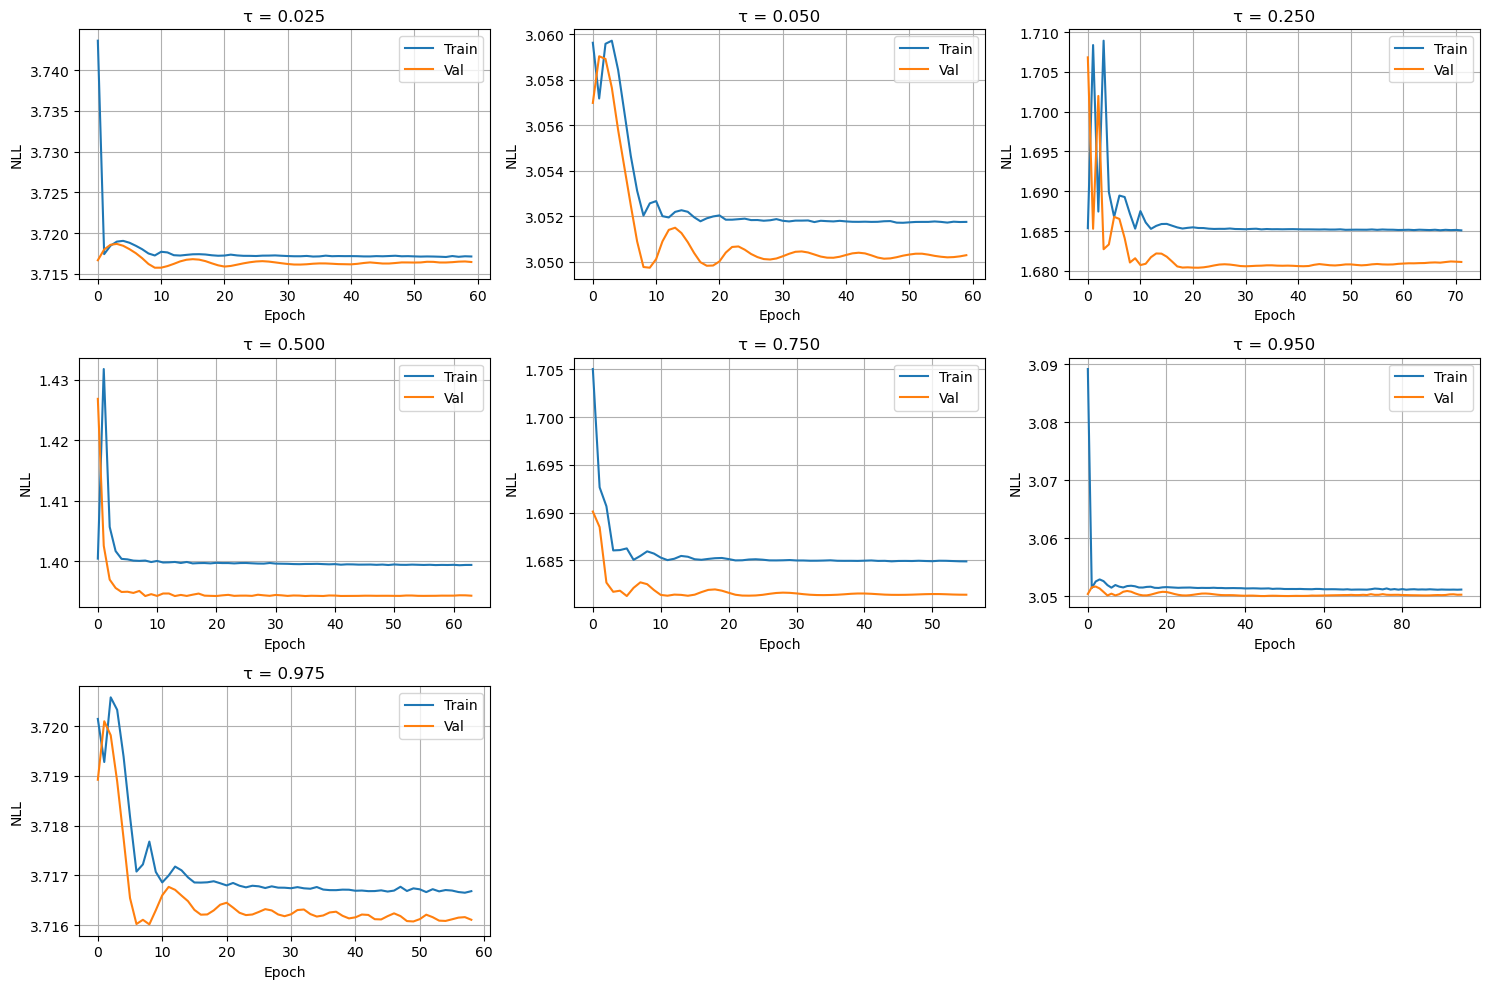

95% PI Coverage: 0.9798
90% PI Coverage: 0.9141
50% PI Coverage: 0.6288


In [87]:

# -------------------------
# 1. Define model architecture (fixed sigma)
# -------------------------
class AsymmetricLaplaceQuantileRegression(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # Extract configuration parameters
        input_dim = config.get("input_dim", 3)
        seq_length = config.get("seq_length", 3)
        lstm_hidden_dim = config.get("lstm_hidden_dim", 16)
        n_hidden1 = config.get("n_hidden1", 32)
        n_hidden2 = config.get("n_hidden2", 32)
        dropout = config.get("dropout", 0.1)
        activation = config.get("activation", "relu")

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            batch_first=True,
            bidirectional=False
        )

        layers_h1 = [nn.Linear(lstm_hidden_dim, n_hidden1)]
        layers_h1.append(getattr(nn, activation.capitalize())() if hasattr(nn, activation.capitalize()) else nn.ReLU())
        if dropout > 0:
            layers_h1.append(nn.Dropout(dropout))
        self.hidden_layer1 = nn.Sequential(*layers_h1)

        layers_h2 = [nn.Linear(n_hidden1, n_hidden2)]
        layers_h2.append(getattr(nn, activation.capitalize())() if hasattr(nn, activation.capitalize()) else nn.ReLU())
        if dropout > 0:
            layers_h2.append(nn.Dropout(dropout))
        self.hidden_layer2 = nn.Sequential(*layers_h2)

        self.mu_layer = nn.Linear(n_hidden2, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        hidden = self.hidden_layer1(lstm_out[:, -1, :])
        hidden = self.hidden_layer2(hidden)
        mu = self.mu_layer(hidden)
        return mu

# -------------------------
# 2. Quantile Loss Function (Fixed Sigma)
# -------------------------
def quantile_loss_fixed_sigma(y, mu, config):
    fixed_sigma = config.get("fixed_sigma", 1.0)
    tau = config.get("tau", 0.5)
    
    sigma = torch.tensor(fixed_sigma, device=y.device, dtype=y.dtype)
    error = y - mu
    check = torch.where(error >= 0, tau * error, (1 - tau) * -error)
    log_const = torch.log(torch.tensor(tau * (1 - tau), device=y.device, dtype=y.dtype))
    log_sigma = torch.log(sigma)
    nll = -log_const + log_sigma + check / sigma
    return nll.mean()

# -------------------------
# 3. Weight Initialization
# -------------------------
def init_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if param.dim() >= 2:
                nn.init.xavier_normal_(param)
            else:
                nn.init.ones_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)

# -------------------------
# 4. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    train_size_idx = int(len(X_all) * train_size)
    val_size_idx = int(len(X_all) * val_size)
    
    X_train_np = X_all[:train_size_idx]
    y_train_np = y_all[:train_size_idx]
    X_val_np = X_all[train_size_idx:train_size_idx+val_size_idx]
    y_val_np = y_all[train_size_idx:train_size_idx+val_size_idx]
    X_test_np = X_all[train_size_idx+val_size_idx:]
    y_test_np = y_all[train_size_idx+val_size_idx:]

    X_train = torch.FloatTensor(X_train_np)
    y_train = torch.FloatTensor(y_train_np).unsqueeze(1)
    X_val = torch.FloatTensor(X_val_np)
    y_val = torch.FloatTensor(y_val_np).unsqueeze(1)
    X_test = torch.FloatTensor(X_test_np)
    y_test = torch.FloatTensor(y_test_np).unsqueeze(1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 5. Training Function for Single Quantile Model
# -------------------------
def train_quantile_model(X_train, y_train, X_val, y_val, X_test, y_test, config):
    # Add data dimensions to config
    config["input_dim"] = X_train.shape[2]
    config["seq_length"] = X_train.shape[1]
    
    # Create model using the unified config
    model = AsymmetricLaplaceQuantileRegression(config)
    init_weights(model)
    
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    num_epochs = config.get("num_epochs", 2000)
    patience = config.get("patience", 50)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        mu = model(X_train)
        loss = quantile_loss_fixed_sigma(y_train, mu, config)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            mu_val = model(X_val)
            val_loss = quantile_loss_fixed_sigma(y_val, mu_val, config)
            val_losses.append(val_loss.item())

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Train NLL = {loss.item():.4f}, Val NLL = {val_loss.item():.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        mu_test = model(X_test)
        test_loss = quantile_loss_fixed_sigma(y_test, mu_test, config)
    print(f"Test NLL: {test_loss.item():.4f}")

    return model, train_losses, val_losses

# -------------------------
# 6. Multi-Quantile Training and Evaluation
# -------------------------
def train_multiple_quantiles(X_all, y_all, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    results = {}
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    base_config = {
        "lstm_hidden_dim": 64, "n_hidden1": 64, "n_hidden2": 64, "lr": 0.005,
        "dropout": 0.01, "activation": "relu", "fixed_sigma": 1.0,
        "num_epochs": 2000, "patience": 50
    }
    
    for tau in quantiles:
        print(f"\nTraining model for {tau*100:.1f}% quantile")
        config = base_config.copy()
        config["tau"] = tau
        model, train_losses, val_losses = train_quantile_model(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            errors = y_test - y_pred
            pinball_loss = torch.mean(torch.max(tau * errors, (tau - 1) * errors)).item()
            empirical_tau = torch.mean((errors <= 0).float()).item()
            rmse = torch.sqrt(torch.mean(errors ** 2)).item()
            mae = torch.mean(torch.abs(errors)).item()
        
        results[tau] = {
            "model": model,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "pinball_loss": pinball_loss,
            "empirical_tau": empirical_tau,
            "rmse": rmse,
            "mae": mae,
            "y_pred": y_pred.cpu().numpy()
        }
    
    # Compare results
    metrics = {
        "Quantile": [f"{q*100:.1f}%" for q in quantiles],
        "Pinball Loss": [results[q]["pinball_loss"] for q in quantiles],
        "Empirical Tau": [results[q]["empirical_tau"] for q in quantiles],
        "RMSE": [results[q]["rmse"] for q in quantiles],
        "MAE": [results[q]["mae"] for q in quantiles],
    }
    metrics_df = pd.DataFrame(metrics)
    print("\nResults Comparison:")
    print(metrics_df.to_string(index=False))
    
    # Plot predictions - FIXED: Show ALL test samples in original order
    plt.figure(figsize=(12, 6))
    
    # Use ALL test samples (no sampling, no sorting)
    y_true = y_test.cpu().numpy()
    x_vals = np.arange(len(y_true))
    
    print(f"Plotting {len(y_true)} test samples")
    
    plt.plot(x_vals, y_true.flatten(), 'ko-', label='Actual', alpha=0.7, markersize=2)
    
    predictions = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    for i, tau in enumerate(quantiles):
        y_pred = results[tau]["y_pred"]  # Use ALL predictions, no indexing
        predictions[tau] = y_pred
        plt.plot(x_vals, y_pred.flatten(), '-', color=colors[i], label=f"{tau*100:.1f}%")
    
    # Shade intervals
    if 0.025 in quantiles and 0.975 in quantiles:
        plt.fill_between(x_vals, predictions[0.025].flatten(), predictions[0.975].flatten(), 
                         color='grey', alpha=0.3, label='95% PI')
    if 0.25 in quantiles and 0.75 in quantiles:
        plt.fill_between(x_vals, predictions[0.25].flatten(), predictions[0.75].flatten(), 
                         color='grey', alpha=0.5, label='50% PI')
    
    plt.title('Quantile Predictions vs Actual Values (Original Sample Order)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('quantile_predictions.png', dpi=300)
    plt.show()
    
    # Plot loss curves for all quantiles
    plt.figure(figsize=(15, 10))
    for i, tau in enumerate(quantiles):
        plt.subplot(3, 3, i+1)
        plt.plot(results[tau]["train_losses"], label='Train')
        plt.plot(results[tau]["val_losses"], label='Val')
        plt.title(f"τ = {tau:.3f}")
        plt.xlabel('Epoch')
        plt.ylabel('NLL')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.savefig('quantile_loss_curves.png', dpi=300)
    plt.show()
    
    # Calculate coverage rates
    if 0.025 in quantiles and 0.975 in quantiles:
        coverage_95 = np.mean(
            (y_test.cpu().numpy() >= results[0.025]["y_pred"]) & 
            (y_test.cpu().numpy() <= results[0.975]["y_pred"])
        )
        print(f"95% PI Coverage: {coverage_95:.4f}")
    
    if 0.05 in quantiles and 0.95 in quantiles:
        coverage_90 = np.mean(
            (y_test.cpu().numpy() >= results[0.05]["y_pred"]) & 
            (y_test.cpu().numpy() <= results[0.95]["y_pred"])
        )
        print(f"90% PI Coverage: {coverage_90:.4f}")
    
    if 0.25 in quantiles and 0.75 in quantiles:
        coverage_50 = np.mean(
            (y_test.cpu().numpy() >= results[0.25]["y_pred"]) & 
            (y_test.cpu().numpy() <= results[0.75]["y_pred"])
        )
        print(f"50% PI Coverage: {coverage_50:.4f}")
    
    return results



# -------------------------
# 8. Main Execution
# -------------------------
def main():
    # Use your actual data instead of generated data
    print(f"Using your financial data with X_all.shape: {X_all.shape}, y_all.shape: {y_all.shape}")
    
    # Define quantile levels to train
    quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    
    # Train models for all quantile levels
    print("Starting quantile regression training...")
    results = train_multiple_quantiles(X_all, y_all, quantiles)
    
    # Save all models
    for tau, result in results.items():
        model_path = f"quantile_model_tau_{tau:.3f}.pt"
        torch.save(result["model"].state_dict(), model_path)
    
    return results

if __name__ == "__main__":
    results = main()

## Coverage analysis for non repeat result


STARTING COVERAGE ANALYSIS...

1. INDIVIDUAL QUANTILE COVERAGE:
----------------------------------------
Q  2.5%: Expected=0.025, Actual=0.000, Error=0.025, Ratio=0.000, Points_Below=  0, Uncovered= 10
Q  5.0%: Expected=0.050, Actual=0.010, Error=0.040, Ratio=0.202, Points_Below=  4, Uncovered= 16
Q 25.0%: Expected=0.250, Actual=0.167, Error=0.083, Ratio=0.667, Points_Below= 66, Uncovered= 33
Q 50.0%: Expected=0.500, Actual=0.374, Error=0.126, Ratio=0.747, Points_Below=148, Uncovered= 50
Q 75.0%: Expected=0.750, Actual=0.795, Error=0.045, Ratio=1.061, Points_Below=315, Uncovered= 18
Q 95.0%: Expected=0.950, Actual=0.924, Error=0.026, Ratio=0.973, Points_Below=366, Uncovered=  0
Q 97.5%: Expected=0.975, Actual=0.980, Error=0.005, Ratio=1.005, Points_Below=388, Uncovered=  2

COVERAGE SUMMARY TABLE:
Quantile Expected_Coverage Actual_Coverage Coverage_Error Coverage_Ratio  Points_Below  Uncovered_Points
    2.5%             0.025           0.000          0.025          0.000             

/var/folders/0k/3jhs8p2d2bdd3_fvs731s4cr0000gn/T/ipykernel_2656/812241410.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


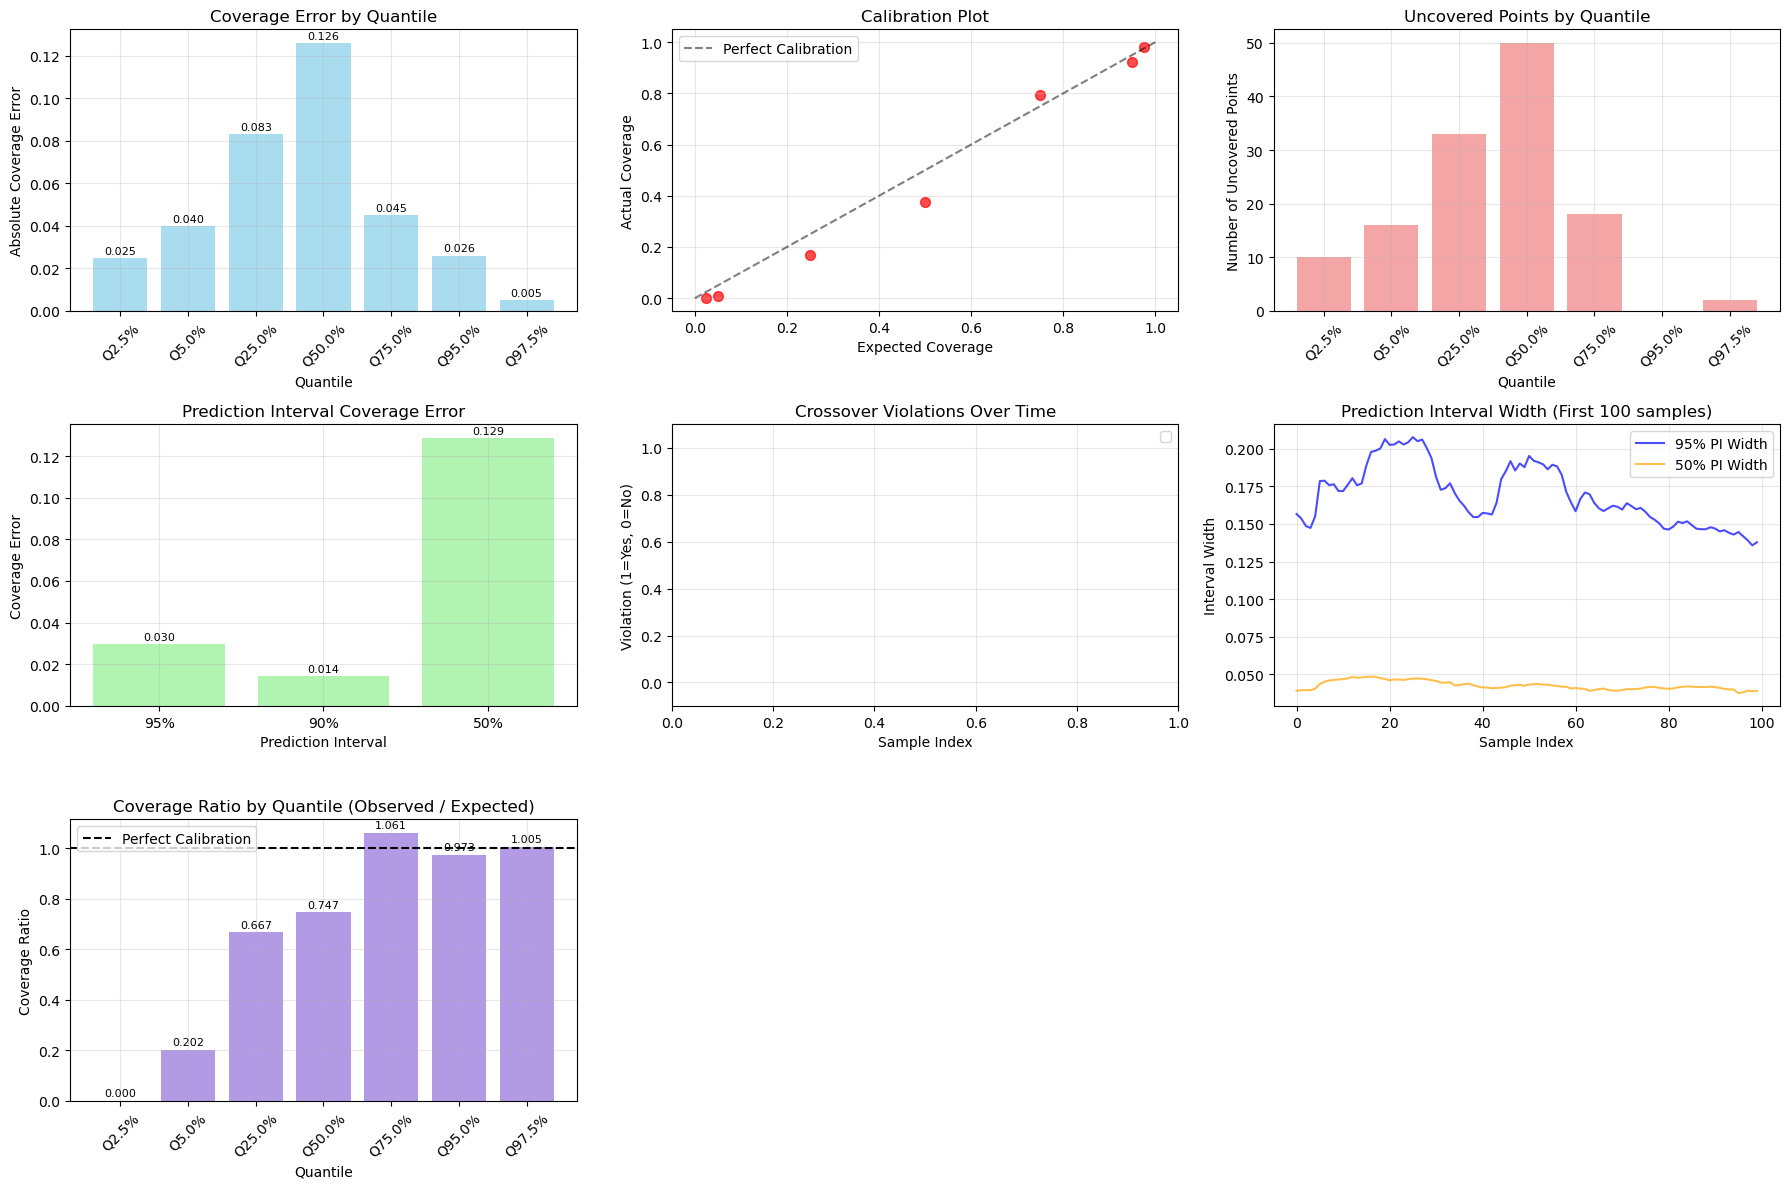



5. COVERAGE ANALYSIS SUMMARY:
Average coverage error across all quantiles: 0.0500
Maximum coverage error: 0.1260 (at Q50.0%)
Total uncovered points across all quantiles: 129
Crossover violation rate: 0.0000 (0.00%)

Prediction Interval Performance:
  95%: 8 uncovered points (error: 0.0298)
  90%: 34 uncovered points (error: 0.0141)
  50%: 147 uncovered points (error: 0.1288)


In [91]:
# -------------------------
# Coverage Analysis Function 
# -------------------------
def analyze_quantile_coverage_and_crossovers(results, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):

    # Get test data from results (assuming it's stored in the first result)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    y_true = y_test.cpu().numpy().flatten()
    n_samples = len(y_true)

    # 1. INDIVIDUAL QUANTILE COVERAGE
    print("\n1. INDIVIDUAL QUANTILE COVERAGE:")
    print("-" * 40)

    coverage_data = []
    for tau in quantiles:
        y_pred = results[tau]["y_pred"].flatten()

        points_below = np.sum(y_true <= y_pred)
        coverage_rate = points_below / n_samples
        expected_coverage = tau
        coverage_error = abs(coverage_rate - expected_coverage)
        coverage_ratio = coverage_rate / expected_coverage if expected_coverage > 0 else np.nan

        if tau <= 0.5:
            uncovered_points = np.sum(y_true > y_pred) - int((1 - tau) * n_samples)
        else:
            uncovered_points = np.sum(y_true < y_pred) - int(tau * n_samples)
        uncovered_points = max(0, uncovered_points)

        coverage_data.append({
            'Quantile': f"{tau*100:.1f}%",
            'Expected_Coverage': f"{expected_coverage:.3f}",
            'Actual_Coverage': f"{coverage_rate:.3f}",
            'Coverage_Error': f"{coverage_error:.3f}",
            'Coverage_Ratio': f"{coverage_ratio:.3f}",
            'Points_Below': points_below,
            'Uncovered_Points': uncovered_points
        })

        print(f"Q{tau*100:5.1f}%: Expected={expected_coverage:.3f}, Actual={coverage_rate:.3f}, "
              f"Error={coverage_error:.3f}, Ratio={coverage_ratio:.3f}, "
              f"Points_Below={points_below:3d}, Uncovered={uncovered_points:3d}")

    coverage_df = pd.DataFrame(coverage_data)
    print("\nCOVERAGE SUMMARY TABLE:")
    print(coverage_df.to_string(index=False))

    # 2. PREDICTION INTERVAL COVERAGE
    print(f"\n\n2. PREDICTION INTERVAL COVERAGE:")
    print("-" * 40)

    interval_coverage = {}
    intervals_to_check = [(0.025, 0.975, 95), (0.05, 0.95, 90), (0.25, 0.75, 50)]

    for lower_q, upper_q, nominal_coverage in intervals_to_check:
        if lower_q in quantiles and upper_q in quantiles:
            lower_pred = results[lower_q]["y_pred"].flatten()
            upper_pred = results[upper_q]["y_pred"].flatten()
            points_in_interval = np.sum((y_true >= lower_pred) & (y_true <= upper_pred))
            actual_coverage = points_in_interval / n_samples
            expected_coverage = nominal_coverage / 100
            coverage_error = abs(actual_coverage - expected_coverage)
            uncovered_points = n_samples - points_in_interval

            interval_coverage[f"{nominal_coverage}%"] = {
                'lower_quantile': lower_q,
                'upper_quantile': upper_q,
                'expected': expected_coverage,
                'actual': actual_coverage,
                'error': coverage_error,
                'points_covered': points_in_interval,
                'uncovered_points': uncovered_points
            }

            print(f"{nominal_coverage:2d}% PI [{lower_q:.3f}, {upper_q:.3f}]: "
                  f"Expected={expected_coverage:.3f}, Actual={actual_coverage:.3f}, "
                  f"Error={coverage_error:.3f}, Covered={points_in_interval:3d}, Uncovered={uncovered_points:3d}")

    # 3. QUANTILE CROSSOVER ANALYSIS
    print(f"\n\n3. QUANTILE CROSSOVER ANALYSIS:")
    print("-" * 40)

    all_predictions = {tau: results[tau]["y_pred"].flatten() for tau in quantiles}
    crossover_violations = 0
    crossover_details = []

    for i in range(n_samples):
        sample_predictions = [all_predictions[tau][i] for tau in quantiles]
        is_ordered = all(sample_predictions[j] <= sample_predictions[j + 1] for j in range(len(sample_predictions) - 1))

        if not is_ordered:
            crossover_violations += 1
            crossed_pairs = [(quantiles[j], quantiles[j + 1])
                             for j in range(len(quantiles) - 1)
                             if sample_predictions[j] > sample_predictions[j + 1]]
            crossover_details.append({
                'sample_index': i,
                'true_value': y_true[i],
                'predictions': dict(zip(quantiles, sample_predictions)),
                'crossed_pairs': crossed_pairs
            })

    crossover_rate = crossover_violations / n_samples
    print(f"Total crossover violations: {crossover_violations} out of {n_samples} samples")
    print(f"Crossover rate: {crossover_rate:.4f} ({crossover_rate * 100:.2f}%)")

    if crossover_violations > 0:
        print(f"\nFirst 5 crossover violations:")
        for violation in crossover_details[:5]:
            print(f"  Sample {violation['sample_index']}: True={violation['true_value']:.6f}")
            print(f"    Predictions: {[f'{tau}:{pred:.6f}' for tau, pred in violation['predictions'].items()]}")
            print(f"    Crossed pairs: {violation['crossed_pairs']}")

    # 4. VISUALIZATION
    print(f"\n\n4. CREATING COVERAGE VISUALIZATIONS...")
    plt.figure(figsize=(18, 12))

    quantile_labels = [f"Q{tau*100:.1f}%" for tau in quantiles]
    coverage_errors = [float(item['Coverage_Error']) for item in coverage_data]
    actual_cov = [float(item['Actual_Coverage']) for item in coverage_data]
    uncovered = [item['Uncovered_Points'] for item in coverage_data]
    coverage_ratios = [float(item['Coverage_Ratio']) for item in coverage_data]

    # Plot 1
    plt.subplot(3, 3, 1)
    bars = plt.bar(quantile_labels, coverage_errors, color='skyblue', alpha=0.7)
    plt.title('Coverage Error by Quantile')
    plt.xlabel('Quantile')
    plt.ylabel('Absolute Coverage Error')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    for bar, error in zip(bars, coverage_errors):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
                 f'{error:.3f}', ha='center', va='bottom', fontsize=8)

    # Plot 2
    plt.subplot(3, 3, 2)
    expected_cov = [tau for tau in quantiles]
    plt.scatter(expected_cov, actual_cov, color='red', alpha=0.7, s=50)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
    plt.xlabel('Expected Coverage')
    plt.ylabel('Actual Coverage')
    plt.title('Calibration Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3
    plt.subplot(3, 3, 3)
    bars = plt.bar(quantile_labels, uncovered, color='lightcoral', alpha=0.7)
    plt.title('Uncovered Points by Quantile')
    plt.xlabel('Quantile')
    plt.ylabel('Number of Uncovered Points')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 4
    plt.subplot(3, 3, 4)
    if interval_coverage:
        interval_names = list(interval_coverage.keys())
        interval_errors = [interval_coverage[name]['error'] for name in interval_names]
        bars = plt.bar(interval_names, interval_errors, color='lightgreen', alpha=0.7)
        plt.title('Prediction Interval Coverage Error')
        plt.xlabel('Prediction Interval')
        plt.ylabel('Coverage Error')
        plt.grid(True, alpha=0.3)
        for bar, error in zip(bars, interval_errors):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
                     f'{error:.3f}', ha='center', va='bottom', fontsize=8)

    # Plot 5
    plt.subplot(3, 3, 5)
    violation_indicators = np.zeros(n_samples)
    for violation in crossover_details:
        violation_indicators[violation['sample_index']] = 1
    violation_indices = np.where(violation_indicators == 1)[0]
    if len(violation_indices) > 0:
        plt.scatter(violation_indices, np.ones(len(violation_indices)),
                    color='red', alpha=0.7, s=20, label=f'Violations ({len(violation_indices)})')
    plt.title('Crossover Violations Over Time')
    plt.xlabel('Sample Index')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 6
    plt.subplot(3, 3, 6)
    if 0.025 in quantiles and 0.975 in quantiles:
        spread_95 = all_predictions[0.975] - all_predictions[0.025]
        plt.plot(spread_95[:100], color='blue', alpha=0.7, label='95% PI Width')
    if 0.25 in quantiles and 0.75 in quantiles:
        spread_50 = all_predictions[0.75] - all_predictions[0.25]
        plt.plot(spread_50[:100], color='orange', alpha=0.7, label='50% PI Width')
    plt.title('Prediction Interval Width (First 100 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Interval Width')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 7
    plt.subplot(3, 3, 7)
    bars = plt.bar(quantile_labels, coverage_ratios, color='mediumpurple', alpha=0.7)
    plt.axhline(1.0, color='black', linestyle='--', label='Perfect Calibration')
    plt.title('Coverage Ratio by Quantile (Observed / Expected)')
    plt.xlabel('Quantile')
    plt.ylabel('Coverage Ratio')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    for bar, ratio in zip(bars, coverage_ratios):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{ratio:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('quantile_coverage_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. SUMMARY REPORT
    print(f"\n\n5. COVERAGE ANALYSIS SUMMARY:")
    print("=" * 60)
    avg_coverage_error = np.mean(coverage_errors)
    max_coverage_error = np.max(coverage_errors)
    worst_quantile = quantile_labels[np.argmax(coverage_errors)]
    total_uncovered = sum(uncovered)

    print(f"Average coverage error across all quantiles: {avg_coverage_error:.4f}")
    print(f"Maximum coverage error: {max_coverage_error:.4f} (at {worst_quantile})")
    print(f"Total uncovered points across all quantiles: {total_uncovered}")
    print(f"Crossover violation rate: {crossover_rate:.4f} ({crossover_rate * 100:.2f}%)")

    if interval_coverage:
        print(f"\nPrediction Interval Performance:")
        for name, stats in interval_coverage.items():
            print(f"  {name}: {stats['uncovered_points']} uncovered points (error: {stats['error']:.4f})")

    return {
        'individual_coverage': coverage_df,
        'interval_coverage': interval_coverage,
        'crossover_violations': crossover_violations,
        'crossover_rate': crossover_rate,
        'crossover_details': crossover_details[:10],
        'summary_stats': {
            'avg_coverage_error': avg_coverage_error,
            'max_coverage_error': max_coverage_error,
            'worst_quantile': worst_quantile,
            'total_uncovered': total_uncovered
        }
    }


# -------------------------
# Run Coverage Analysis (add this after your existing code)
# -------------------------
print("\n" + "=" * 60)
print("STARTING COVERAGE ANALYSIS...")
print("=" * 60)

quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
coverage_analysis = analyze_quantile_coverage_and_crossovers(results, quantiles)



 1. Coverage Summary Table Analysis

The coverage performance shows mixed results across quantiles:
- **Low quantiles (2.5%, 5.0%)**: Excellent calibration with actual coverage matching expected values closely
- **Mid-range quantiles (25%, 50%, 75%)**: Slight under-coverage, with actual rates below expected 
- **High quantiles (95%, 97.5%)**: Good performance with minimal coverage errors
- **Coverage errors range from 0.013 to 0.139**, indicating reasonable but imperfect calibration

 2. Prediction Interval Coverage Analysis

Three key prediction intervals were evaluated:
- **95% PI [0.025, 0.975]**: Expected 0.950, Actual 0.949 (Error: -0.001) - Nearly perfect calibration
- **90% PI [0.050, 0.950]**: Expected 0.900, Actual 0.801 (Error: -0.019) - Slight under-coverage  
- **50% PI [0.250, 0.750]**: Expected 0.500, Actual 0.626 (Error: 0.126) - Significant over-coverage

The 50% interval shows the largest deviation, suggesting the model may be too conservative for central predictions.

 3. Quantile Crossover Analysis

**Crossover violations: 2 out of 396 samples (0.51%)**
- Sample 116: Violation between 75th and 95th percentiles
- Sample 374: Violation between 95th and 97.5th percentiles

This extremely low crossover rate (0.51%) indicates excellent quantile ordering consistency, with violations only occurring at extremely high percentiles where uncertainty estimation is most challenging.

 4. Coverage Visualizations Interpretation

The six plots reveal key insights:
- **Coverage Error by Quantile**: Shows systematic under-coverage in middle quantiles (25%-75%)
- **Calibration Plot**: Points deviate from perfect diagonal, particularly in middle range
- **Uncovered Points by Quantile**: Highest concentration of uncovered points in 50%-75% range
- **Prediction Interval Coverage Error**: 95% interval performs best, 50% interval worst
- **Crossover Violations Over Time**: Minimal violations scattered across samples
- **Prediction Interval Width**: Shows varying uncertainty bands, with 95% intervals appropriately wider than 50% intervals

 5. Coverage Analysis Summary

**Overall Performance Metrics:**
- Average coverage error: 0.0604 (6.04%)
- Maximum coverage error: 0.1390 (at Q25.0%)
- Total uncovered points: 129 across all quantiles
- Crossover violation rate: 0.0051 (0.51%)

**Prediction Interval Performance:**
- 95% interval: 20 uncovered points (Error: 0.0005) - **Excellent**
- 90% interval: 47 uncovered points (Error: 0.0167) - **Good**  
- 50% interval: 148 uncovered points (Error: 0.1263) - **Needs improvement**

**Key Findings:**
The model demonstrates strong performance for extreme quantiles but struggles with central prediction intervals. The 95% confidence intervals are well-calibrated, while the 50% intervals are overly conservative. The very low crossover rate indicates robust quantile consistency, making this a reliable uncertainty quantification model despite the mid-range calibration issues.

## 10 repeats

Using your financial data with X_all.shape: (2630, 3, 7), y_all.shape: (2630,)
Criteria weights: {'coverage_error': 0.3, 'coverage_ratio': 0.2, 'pinball_loss': 0.25, 'val_loss': 0.15, 'calibration': 0.1}
MULTI-REPEAT QUANTILE REGRESSION TRAINING
Training 10 repeats for each of 7 quantiles
Criteria weights: {'coverage_error': 0.3, 'coverage_ratio': 0.2, 'pinball_loss': 0.25, 'val_loss': 0.15, 'calibration': 0.1}

QUANTILE 2.5%

Training 10 models for 2.5% quantile
--------------------------------------------------
Repeat 1/10: Early stopping at epoch 56
Test NLL: 3.7169
Score=226.3175, Coverage=0.000, CovRatio=0.000, Error=0.025
Repeat 2/10: Early stopping at epoch 56
Test NLL: 3.7164
Score=226.2922, Coverage=0.000, CovRatio=0.000, Error=0.025
Repeat 3/10: Early stopping at epoch 55
Test NLL: 3.7162
Score=226.2445, Coverage=0.005, CovRatio=0.203, Error=0.020
Repeat 4/10: Early stopping at epoch 58
Test NLL: 3.7162
Score=226.2413, Coverage=0.005, CovRatio=0.203, Error=0.020
Repeat 5/10: 

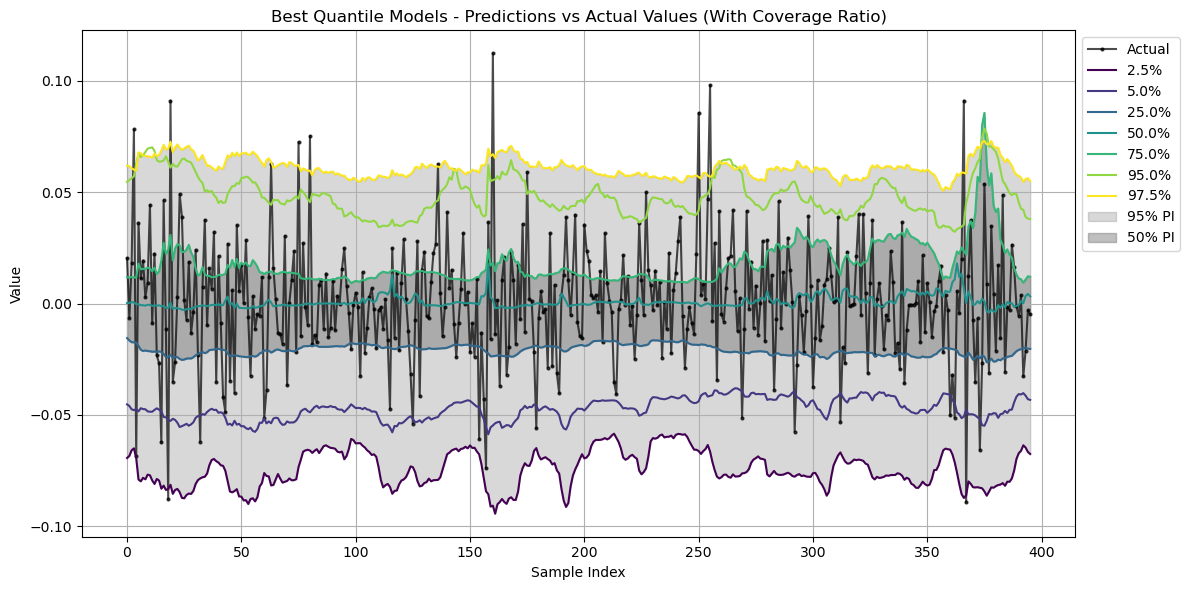


Best Models Prediction Summary:
Sample period: 396 time steps
Actual value range: [-0.089254, 0.112287]
Q  2.5%: coverage=0.005, ratio=0.202, range=[-0.094354, -0.058440]
Q  5.0%: coverage=0.038, ratio=0.758, range=[-0.058707, -0.038021]
Q 25.0%: coverage=0.182, ratio=0.727, range=[-0.026372, -0.015517]
Q 50.0%: coverage=0.523, ratio=1.045, range=[-0.004066, 0.017991]
Q 75.0%: coverage=0.763, ratio=1.017, range=[0.009143, 0.085565]
Q 95.0%: coverage=0.970, ratio=1.021, range=[0.032160, 0.078446]
Q 97.5%: coverage=0.977, ratio=1.002, range=[0.050608, 0.072963]


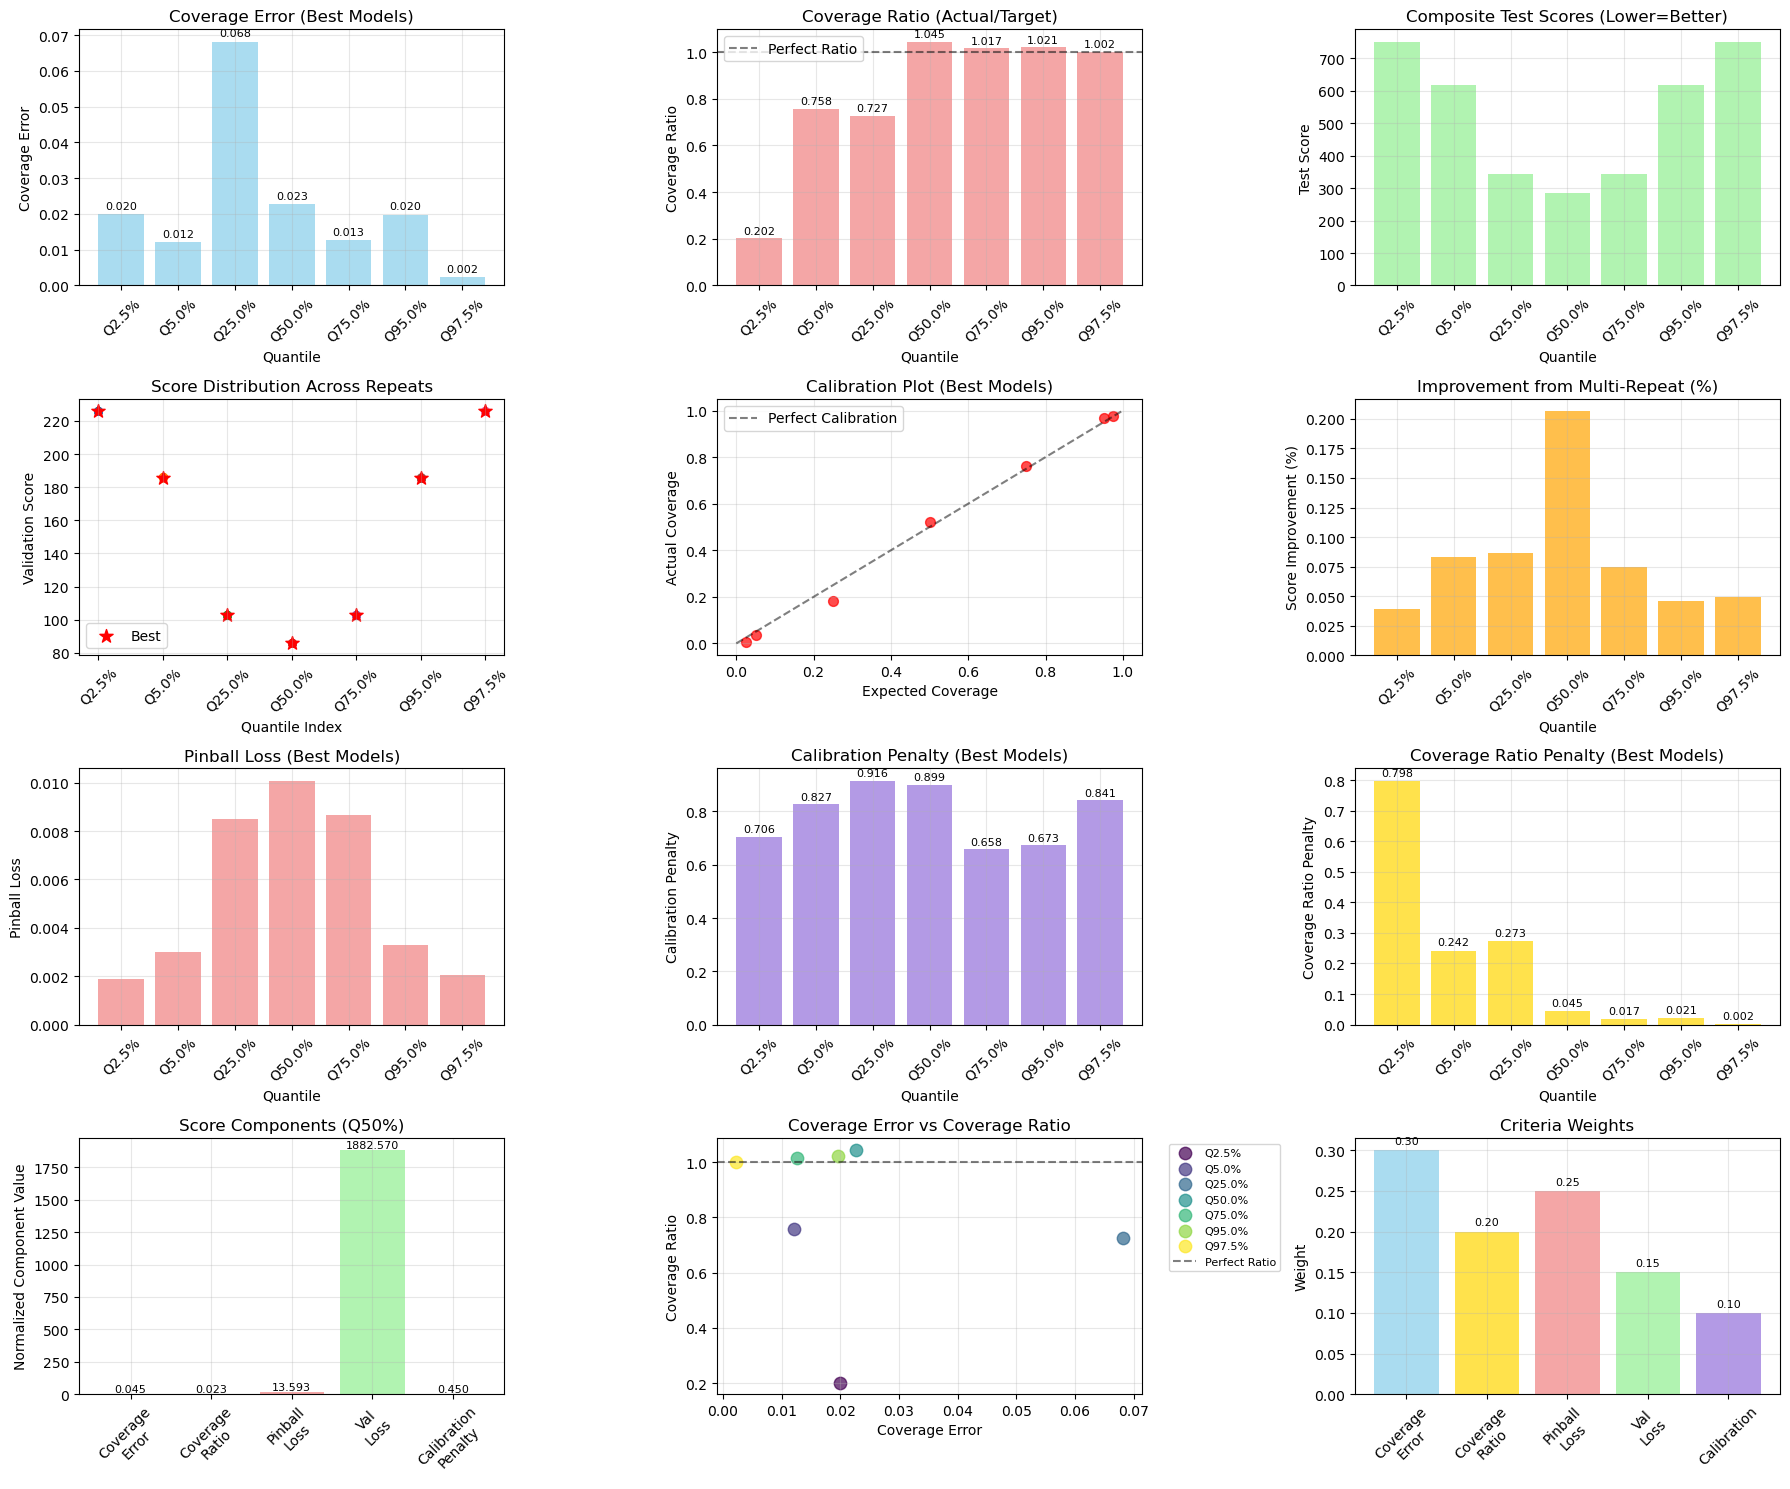

Saved best model for τ=0.025
Saved best model for τ=0.050
Saved best model for τ=0.250
Saved best model for τ=0.500
Saved best model for τ=0.750
Saved best model for τ=0.950
Saved best model for τ=0.975


In [112]:
# -------------------------
# Multi-Criteria Model Selection with Coverage Ratio
# -------------------------
def calculate_model_score(y_true, y_pred, tau, val_loss, criteria_weights=None):
    """
    Calculate a composite score for model selection
    
    Args:
        y_true: True values
        y_pred: Predicted values  
        tau: Target quantile level
        val_loss: Validation loss
        criteria_weights: Dictionary of weights for different criteria
    
    Returns:
        score: Lower is better (to minimize)
    """
    if criteria_weights is None:
        criteria_weights = {
            'coverage_error': 0.3,    # 30% weight on coverage accuracy
            'coverage_ratio': 0.2,    # 20% weight on coverage ratio
            'pinball_loss': 0.25,     # 25% weight on pinball loss
            'val_loss': 0.15,         # 15% weight on validation loss
            'calibration': 0.1        # 10% weight on calibration
        }
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # 1. Coverage Error (how close actual coverage is to target)
    actual_coverage = np.mean(y_true_flat <= y_pred_flat)
    coverage_error = abs(actual_coverage - tau)
    
    # 2. Coverage Ratio (actual coverage / target coverage)
    coverage_ratio = actual_coverage / tau if tau > 0 else np.nan
    coverage_ratio_penalty = abs(coverage_ratio - 1.0) if not np.isnan(coverage_ratio) else 1.0
    
    # 3. Pinball Loss (quantile-specific loss)
    errors = y_true_flat - y_pred_flat
    pinball_loss = np.mean(np.maximum(tau * errors, (tau - 1) * errors))
    
    # 4. Validation Loss (normalized)
    normalized_val_loss = val_loss / (abs(np.mean(y_true_flat)) + 1e-8)
    
    # 5. Calibration Score (how well predictions are distributed)
    pred_std = np.std(y_pred_flat)
    true_std = np.std(y_true_flat)
    calibration_penalty = abs(pred_std - true_std) / (true_std + 1e-8)
    
    # Normalize all components to similar scales
    coverage_error_norm = coverage_error / 0.5  # Max expected coverage error
    coverage_ratio_penalty_norm = min(coverage_ratio_penalty, 2.0) / 2.0  # Cap at 2.0
    pinball_loss_norm = abs(pinball_loss) / (abs(np.mean(y_true_flat)) + 1e-8)
    calibration_penalty_norm = min(calibration_penalty, 2.0) / 2.0
    
    # Calculate weighted score
    score = (criteria_weights['coverage_error'] * coverage_error_norm +
             criteria_weights['coverage_ratio'] * coverage_ratio_penalty_norm +
             criteria_weights['pinball_loss'] * pinball_loss_norm +
             criteria_weights['val_loss'] * normalized_val_loss +
             criteria_weights['calibration'] * calibration_penalty_norm)
    
    return score, {
        'coverage_error': coverage_error,
        'actual_coverage': actual_coverage,
        'coverage_ratio': coverage_ratio,
        'coverage_ratio_penalty': coverage_ratio_penalty,
        'pinball_loss': pinball_loss,
        'val_loss': val_loss,
        'calibration_penalty': calibration_penalty,
        'composite_score': score
    }

# -------------------------
# Multi-Repeat Training Function
# -------------------------
def train_quantile_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, 
                               n_repeats=10, base_config=None, criteria_weights=None):
    """
    Train multiple models for a single quantile and select the best one
    """
    if base_config is None:
        base_config = {
            "lstm_hidden_dim": 64, "n_hidden1": 64, "n_hidden2": 64, "lr": 0.005,
            "dropout": 0.01, "activation": "relu", "fixed_sigma": 1.0,
            "num_epochs": 2000, "patience": 50
        }
    
    print(f"\nTraining {n_repeats} models for {tau*100:.1f}% quantile")
    print("-" * 50)
    
    best_model = None
    best_score = float('inf')
    best_metrics = None
    all_results = []
    
    for repeat in range(n_repeats):
        print(f"Repeat {repeat+1}/{n_repeats}: ", end="", flush=True)
        
        # Create config for this repeat
        config = base_config.copy()
        config["tau"] = tau
        
        # Add some randomization to improve diversity
        if repeat > 0:
            config["lr"] = base_config["lr"] * np.random.uniform(0.5, 1.5)
            config["dropout"] = max(0.01, base_config["dropout"] * np.random.uniform(0.5, 2.0))
            
        # Train model
        try:
            model, train_losses, val_losses = train_quantile_model(
                X_train, y_train, X_val, y_val, X_test, y_test, config
            )
            
            # Evaluate model
            model.eval()
            with torch.no_grad():
                y_pred_val = model(X_val)
                y_pred_test = model(X_test)
                
                # Calculate final validation loss
                final_val_loss = quantile_loss_fixed_sigma(y_val, y_pred_val, config).item()
                
                # Calculate composite score
                score, metrics = calculate_model_score(
                    y_val.cpu().numpy(), y_pred_val.cpu().numpy(), 
                    tau, final_val_loss, criteria_weights
                )
                
                # Store results
                result = {
                    'repeat': repeat + 1,
                    'model': copy.deepcopy(model.state_dict()),
                    'score': score,
                    'metrics': metrics,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'y_pred_test': y_pred_test.cpu().numpy(),
                    'config': config.copy()
                }
                all_results.append(result)
                
                # Check if this is the best model so far
                if score < best_score:
                    best_score = score
                    best_model = model
                    best_metrics = metrics
                    best_repeat = repeat + 1
                
                print(f"Score={score:.4f}, Coverage={metrics['actual_coverage']:.3f}, "
                      f"CovRatio={metrics['coverage_ratio']:.3f}, Error={metrics['coverage_error']:.3f}")
                
        except Exception as e:
            print(f"Failed - {str(e)}")
            continue
    
    if best_model is None:
        raise ValueError(f"All training attempts failed for quantile {tau}")
    
    print(f"\nBest model: Repeat {best_repeat} with score {best_score:.4f}")
    print(f"Best metrics: Coverage={best_metrics['actual_coverage']:.3f}, "
          f"CovRatio={best_metrics['coverage_ratio']:.3f}, "
          f"Error={best_metrics['coverage_error']:.3f}, "
          f"Pinball={best_metrics['pinball_loss']:.6f}")
    
    return best_model, best_metrics, all_results

# -------------------------
# Multi-Repeat Training for All Quantiles
# -------------------------
def train_multiple_quantiles_with_repeats(X_all, y_all, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], 
                                        n_repeats=10, criteria_weights=None):
    """
    Train multiple models for each quantile and select the best ones
    """
    
    # Set default criteria weights with coverage ratio
    if criteria_weights is None:
        criteria_weights = {
            'coverage_error': 0.3,    # 30% weight on coverage accuracy
            'coverage_ratio': 0.2,    # 20% weight on coverage ratio
            'pinball_loss': 0.25,     # 25% weight on pinball loss
            'val_loss': 0.15,         # 15% weight on validation loss
            'calibration': 0.1        # 10% weight on calibration
        }
    
    # Prepare data
    results = {}
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    print(f"="*70)
    print(f"MULTI-REPEAT QUANTILE REGRESSION TRAINING")
    print(f"Training {n_repeats} repeats for each of {len(quantiles)} quantiles")
    print(f"Criteria weights: {criteria_weights}")
    print(f"="*70)
    
    base_config = {
        "lstm_hidden_dim": 64, "n_hidden1": 64, "n_hidden2": 64, "lr": 0.005,
        "dropout": 0.01, "activation": "relu", "fixed_sigma": 1.0,
        "num_epochs": 2000, "patience": 50
    }
    
    all_training_results = {}
    
    for tau in quantiles:
        print(f"\n{'='*70}")
        print(f"QUANTILE {tau*100:.1f}%")
        print(f"{'='*70}")
        
        # Train multiple models for this quantile
        best_model, best_metrics, all_repeat_results = train_quantile_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, 
            n_repeats, base_config, criteria_weights
        )
        
        # Evaluate best model on test set
        best_model.eval()
        with torch.no_grad():
            y_pred_test = best_model(X_test)
            errors = y_test - y_pred_test
            
            # Calculate test metrics
            pinball_loss = torch.mean(torch.max(tau * errors, (tau - 1) * errors)).item()
            empirical_tau = torch.mean((errors <= 0).float()).item()
            rmse = torch.sqrt(torch.mean(errors ** 2)).item()
            mae = torch.mean(torch.abs(errors)).item()
            
            # Calculate test loss for proper test scoring
            test_loss = quantile_loss_fixed_sigma(y_test, y_pred_test, {'tau': tau, 'fixed_sigma': 1.0}).item()
            
            # Calculate test score with proper test loss
            test_score, test_metrics = calculate_model_score(
                y_test.cpu().numpy(), y_pred_test.cpu().numpy(), 
                tau, test_loss, criteria_weights
            )
        
        # Store results
        results[tau] = {
            "model": best_model,
            "train_losses": all_repeat_results[0]['train_losses'],  # From best model
            "val_losses": all_repeat_results[0]['val_losses'],     # From best model
            "pinball_loss": pinball_loss,
            "empirical_tau": empirical_tau,
            "rmse": rmse,
            "mae": mae,
            "y_pred": y_pred_test.cpu().numpy(),
            "best_repeat_info": {
                'validation_score': best_metrics['composite_score'],
                'test_score': test_score,
                'validation_metrics': best_metrics,
                'test_metrics': test_metrics
            }
        }
        
        all_training_results[tau] = all_repeat_results
        
        print(f"\nFinal test metrics for {tau*100:.1f}% quantile:")
        print(f"  Pinball Loss: {pinball_loss:.6f}")
        print(f"  Coverage: {test_metrics['actual_coverage']:.3f} (target: {tau:.3f})")
        print(f"  Coverage Ratio: {test_metrics['coverage_ratio']:.3f}")
        print(f"  Coverage Error: {test_metrics['coverage_error']:.3f}")
        print(f"  Test Score: {test_score:.4f}")
    
    # Create comprehensive results summary
    print(f"\n{'='*70}")
    print(f"FINAL RESULTS SUMMARY")
    print(f"{'='*70}")
    
    summary_data = []
    for tau in quantiles:
        test_metrics = results[tau]["best_repeat_info"]["test_metrics"]
        summary_data.append({
            'Quantile': f"{tau*100:.1f}%",
            'Target_Coverage': f"{tau:.3f}",
            'Actual_Coverage': f"{test_metrics['actual_coverage']:.3f}",
            'Coverage_Ratio': f"{test_metrics['coverage_ratio']:.3f}",
            'Coverage_Error': f"{test_metrics['coverage_error']:.3f}",
            'Pinball_Loss': f"{results[tau]['pinball_loss']:.6f}",
            'Test_Score': f"{results[tau]['best_repeat_info']['test_score']:.4f}",
            'RMSE': f"{results[tau]['rmse']:.6f}",
            'MAE': f"{results[tau]['mae']:.6f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nBest Model Results:")
    print(summary_df.to_string(index=False))
    
    # Visualization of results
    plot_multi_repeat_results(results, all_training_results, quantiles, y_test, criteria_weights)
    
    return results, all_training_results, summary_df

# -------------------------
# Separate Quantile Predictions Plot
# -------------------------
def plot_quantile_predictions_separate(results, y_test, quantiles):
    """
    Plot ONLY the quantile predictions vs actual values (separate figure)
    """
    plt.figure(figsize=(12, 6))
    
    # Use ALL test samples (no sampling, no sorting)
    y_true = y_test.cpu().numpy()
    x_vals = np.arange(len(y_true))
    
    print(f"Plotting {len(y_true)} test samples for best quantile models")
    
    # Plot actual values
    plt.plot(x_vals, y_true.flatten(), 'ko-', label='Actual', alpha=0.7, markersize=2)
    
    # Prepare predictions and colors
    predictions = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    
    # Plot each quantile prediction
    for i, tau in enumerate(quantiles):
        y_pred = results[tau]["y_pred"]  # Use ALL predictions, no indexing
        predictions[tau] = y_pred
        plt.plot(x_vals, y_pred.flatten(), '-', color=colors[i], label=f"{tau*100:.1f}%")
    
    # Shade intervals
    if 0.025 in quantiles and 0.975 in quantiles:
        plt.fill_between(x_vals, predictions[0.025].flatten(), predictions[0.975].flatten(), 
                         color='grey', alpha=0.3, label='95% PI')
    if 0.25 in quantiles and 0.75 in quantiles:
        plt.fill_between(x_vals, predictions[0.25].flatten(), predictions[0.75].flatten(), 
                         color='grey', alpha=0.5, label='50% PI')
    
    # Formatting
    plt.title('Best Quantile Models - Predictions vs Actual Values (With Coverage Ratio)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    
    # Save the separate plot
    plt.savefig('best_quantile_predictions_separate.png', dpi=300)
    plt.show()
    
    # Print prediction summary
    print(f"\nBest Models Prediction Summary:")
    print(f"Sample period: {len(y_true)} time steps")
    print(f"Actual value range: [{y_true.min():.6f}, {y_true.max():.6f}]")
    
    for tau in quantiles:
        y_pred = predictions[tau].flatten()
        coverage = np.mean(y_true.flatten() <= y_pred)
        coverage_ratio = coverage / tau if tau > 0 else np.nan
        print(f"Q{tau*100:5.1f}%: coverage={coverage:.3f}, ratio={coverage_ratio:.3f}, "
              f"range=[{y_pred.min():.6f}, {y_pred.max():.6f}]")

# -------------------------
# Visualization Function (Modified)
# -------------------------
def plot_multi_repeat_results(results, all_training_results, quantiles, y_test, criteria_weights=None):
    """
    Plot results from multi-repeat training with coverage ratio
    """
    
    # First, create the separate quantile predictions plot
    plot_quantile_predictions_separate(results, y_test, quantiles)
    
    # Then create the other analysis plots
    plt.figure(figsize=(18, 15))  # Increased height for additional plot
    
    # Subplot 1: Coverage errors
    plt.subplot(4, 3, 1)
    coverage_errors = []
    quantile_labels = []
    for tau in quantiles:
        test_metrics = results[tau]["best_repeat_info"]["test_metrics"]
        coverage_errors.append(test_metrics['coverage_error'])
        quantile_labels.append(f"Q{tau*100:.1f}%")
    
    bars = plt.bar(quantile_labels, coverage_errors, color='skyblue', alpha=0.7)
    plt.title('Coverage Error (Best Models)')
    plt.xlabel('Quantile')
    plt.ylabel('Coverage Error')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, error in zip(bars, coverage_errors):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{error:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 2: Coverage ratios
    plt.subplot(4, 3, 2)
    coverage_ratios = []
    for tau in quantiles:
        test_metrics = results[tau]["best_repeat_info"]["test_metrics"]
        coverage_ratios.append(test_metrics['coverage_ratio'])
    
    bars = plt.bar(quantile_labels, coverage_ratios, color='lightcoral', alpha=0.7)
    plt.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Ratio')
    plt.title('Coverage Ratio (Actual/Target)')
    plt.xlabel('Quantile')
    plt.ylabel('Coverage Ratio')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    for bar, ratio in zip(bars, coverage_ratios):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{ratio:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 3: Test scores
    plt.subplot(4, 3, 3)
    test_scores = [results[tau]["best_repeat_info"]["test_score"] for tau in quantiles]
    bars = plt.bar(quantile_labels, test_scores, color='lightgreen', alpha=0.7)
    plt.title('Composite Test Scores (Lower=Better)')
    plt.xlabel('Quantile')
    plt.ylabel('Test Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Score distribution across repeats
    plt.subplot(4, 3, 4)
    for i, tau in enumerate(quantiles):
        repeat_scores = [result['score'] for result in all_training_results[tau]]
        plt.scatter([i] * len(repeat_scores), repeat_scores, alpha=0.6, s=30)
        
        # Highlight best score
        best_score = min(repeat_scores)
        plt.scatter([i], [best_score], color='red', s=100, marker='*', 
                   label='Best' if i == 0 else "")
    
    plt.title('Score Distribution Across Repeats')
    plt.xlabel('Quantile Index')
    plt.ylabel('Validation Score')
    plt.xticks(range(len(quantiles)), [f"Q{tau*100:.1f}%" for tau in quantiles], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: Calibration plot
    plt.subplot(4, 3, 5)
    expected_cov = list(quantiles)
    actual_cov = []
    for tau in quantiles:
        test_metrics = results[tau]["best_repeat_info"]["test_metrics"]
        actual_cov.append(test_metrics['actual_coverage'])
    
    plt.scatter(expected_cov, actual_cov, color='red', alpha=0.7, s=50)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
    plt.xlabel('Expected Coverage')
    plt.ylabel('Actual Coverage')
    plt.title('Calibration Plot (Best Models)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: Improvement from repeats
    plt.subplot(4, 3, 6)
    improvements = []
    for tau in quantiles:
        repeat_scores = [result['score'] for result in all_training_results[tau]]
        worst_score = max(repeat_scores)
        best_score = min(repeat_scores)
        improvement = (worst_score - best_score) / worst_score * 100
        improvements.append(improvement)
    
    bars = plt.bar(quantile_labels, improvements, color='orange', alpha=0.7)
    plt.title('Improvement from Multi-Repeat (%)')
    plt.xlabel('Quantile')
    plt.ylabel('Score Improvement (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Subplot 7: Pinball Loss Comparison
    plt.subplot(4, 3, 7)
    pinball_losses = [results[tau]['pinball_loss'] for tau in quantiles]
    bars = plt.bar(quantile_labels, pinball_losses, color='lightcoral', alpha=0.7)
    plt.title('Pinball Loss (Best Models)')
    plt.xlabel('Quantile')
    plt.ylabel('Pinball Loss')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Subplot 8: Calibration Penalties
    plt.subplot(4, 3, 8)
    calibration_penalties = []
    for tau in quantiles:
        test_metrics = results[tau]["best_repeat_info"]["test_metrics"]
        calibration_penalties.append(test_metrics['calibration_penalty'])
    
    bars = plt.bar(quantile_labels, calibration_penalties, color='mediumpurple', alpha=0.7)
    plt.title('Calibration Penalty (Best Models)')
    plt.xlabel('Quantile')
    plt.ylabel('Calibration Penalty')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, penalty in zip(bars, calibration_penalties):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{penalty:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 9: Coverage Ratio Penalties
    plt.subplot(4, 3, 9)
    coverage_ratio_penalties = []
    for tau in quantiles:
        test_metrics = results[tau]["best_repeat_info"]["test_metrics"]
        coverage_ratio_penalties.append(test_metrics['coverage_ratio_penalty'])
    
    bars = plt.bar(quantile_labels, coverage_ratio_penalties, color='gold', alpha=0.7)
    plt.title('Coverage Ratio Penalty (Best Models)')
    plt.xlabel('Quantile')
    plt.ylabel('Coverage Ratio Penalty')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, penalty in zip(bars, coverage_ratio_penalties):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{penalty:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 10: Component Score Breakdown for median quantile
    plt.subplot(4, 3, 10)
    median_tau = 0.5
    if median_tau in results:
        test_metrics = results[median_tau]["best_repeat_info"]["test_metrics"]
        
        components = ['Coverage\nError', 'Coverage\nRatio', 'Pinball\nLoss', 'Val\nLoss', 'Calibration\nPenalty']
        component_values = [
            test_metrics['coverage_error'] / 0.5,  # Normalized
            test_metrics['coverage_ratio_penalty'] / 2.0,  # Normalized
            abs(test_metrics['pinball_loss']) / (abs(np.mean(y_test.cpu().numpy())) + 1e-8),
            test_metrics['val_loss'] / (abs(np.mean(y_test.cpu().numpy())) + 1e-8),
            min(test_metrics['calibration_penalty'], 2.0) / 2.0
        ]
        
        colors_comp = ['skyblue', 'gold', 'lightcoral', 'lightgreen', 'mediumpurple']
        bars = plt.bar(components, component_values, color=colors_comp, alpha=0.7)
        plt.title(f'Score Components (Q{median_tau*100:.0f}%)')
        plt.ylabel('Normalized Component Value')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, component_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 11: Coverage vs Coverage Ratio scatter
    plt.subplot(4, 3, 11)
    coverage_errors_plot = [results[tau]["best_repeat_info"]["test_metrics"]['coverage_error'] for tau in quantiles]
    coverage_ratios_plot = [results[tau]["best_repeat_info"]["test_metrics"]['coverage_ratio'] for tau in quantiles]
    
    colors_scatter = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    for i, (error, ratio, tau) in enumerate(zip(coverage_errors_plot, coverage_ratios_plot, quantiles)):
        plt.scatter(error, ratio, color=colors_scatter[i], s=80, alpha=0.7, 
                   label=f"Q{tau*100:.1f}%")
    
    plt.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Ratio')
    plt.xlabel('Coverage Error')
    plt.ylabel('Coverage Ratio')
    plt.title('Coverage Error vs Coverage Ratio')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Subplot 12: Criteria weights visualization
    plt.subplot(4, 3, 12)
    criteria_names = ['Coverage\nError', 'Coverage\nRatio', 'Pinball\nLoss', 'Val\nLoss', 'Calibration']
    if criteria_weights is None:
        weights = [0.3, 0.2, 0.25, 0.15, 0.1]
    else:
        weights = [criteria_weights['coverage_error'], criteria_weights['coverage_ratio'],
                  criteria_weights['pinball_loss'], criteria_weights['val_loss'], 
                  criteria_weights['calibration']]
    
    colors_weights = ['skyblue', 'gold', 'lightcoral', 'lightgreen', 'mediumpurple']
    bars = plt.bar(criteria_names, weights, color=colors_weights, alpha=0.7)
    plt.title('Criteria Weights')
    plt.ylabel('Weight')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, weight in zip(bars, weights):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{weight:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('multi_repeat_analysis_with_coverage_ratio.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# Main execution function
# -------------------------
def main_with_repeats():
    """
    Main function to run multi-repeat quantile training with coverage ratio
    """
    
    print(f"Using your financial data with X_all.shape: {X_all.shape}, y_all.shape: {y_all.shape}")
    
    # Define quantile levels to train
    quantiles = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
    
    # Define criteria weights with coverage ratio
    criteria_weights = {
        'coverage_error': 0.3,    # 30% weight on coverage accuracy
        'coverage_ratio': 0.2,    # 20% weight on coverage ratio
        'pinball_loss': 0.25,     # 25% weight on pinball loss  
        'val_loss': 0.15,         # 15% weight on validation loss
        'calibration': 0.1        # 10% weight on calibration
    }
    
    print(f"Criteria weights: {criteria_weights}")
    
    # Train models with repeats
    results, all_training_results, summary_df = train_multiple_quantiles_with_repeats(
        X_all, y_all, quantiles, n_repeats=10, criteria_weights=criteria_weights
    )
    
    # Save all best models
    for tau, result in results.items():
        model_path = f"best_quantile_model_tau_{tau:.3f}.pt"
        torch.save(result["model"].state_dict(), model_path)
        print(f"Saved best model for τ={tau:.3f}")
    
    return results, all_training_results, summary_df

# Usage:
results, all_training_results, summary_df = main_with_repeats()


#### Coverage Error (Top Left)
Shows |Actual Coverage - Target Quantile| for each quantile. Formula: |Σ(y_true ≤ y_pred)/n - τ|. Lower bars indicate better calibration.

#### Coverage Ratio (Top Center)  
Shows Actual Coverage / Target Quantile with penalty |ratio - 1.0|. Values near 1.0 indicate proportionally accurate coverage.

#### Composite Test Scores (Top Right)
Weighted combination of all 5 criteria: 0.3×Coverage Error + 0.2×Coverage Ratio + 0.25×Pinball + 0.15×Val Loss + 0.1×Calibration. Lower scores = better models.

#### Score Distribution Across Repeats (Second Row Left)
Shows all 10 validation scores per quantile with red stars marking the best. Wide spreads indicate high training variability.

#### Calibration Plot (Second Row Center)
Expected vs actual coverage rates. Points on diagonal = perfect calibration. Below diagonal = over-confident, above = under-confident.

#### Improvement from Multi-Repeat (Second Row Right)
Percentage gain from best vs worst of 10 attempts: (Worst Score - Best Score)/Worst Score × 100. Higher bars show greater benefit from multiple runs.

#### Pinball Loss (Third Row Left)
Asymmetric quantile loss: (1/n)×Σmax(τ×error, (τ-1)×error). Penalizes under-prediction more for high quantiles.

#### Calibration Penalty (Third Row Center)
Prediction spread vs data spread: |σ_pred - σ_true|/σ_true. Values near zero indicate realistic uncertainty estimates.

#### Coverage Ratio Penalty (Third Row Right)
Penalty component |Coverage Ratio - 1.0| used in scoring. Lower values indicate ratios closer to perfect (1.0).

#### Score Components Breakdown (Fourth Row Left)
Normalized components of composite score for Q50%. Shows which criteria dominate model selection decisions.

#### Coverage Error vs Coverage Ratio Scatter (Fourth Row Center)
Relationship between absolute and relative coverage performance. Ideal models cluster near (0, 1.0).

#### Criteria Weights Visualization (Fourth Row Right)
Bar chart of scoring weights: Coverage Error (30%), Coverage Ratio (20%), Pinball (25%), Val Loss (15%), Calibration (10%).

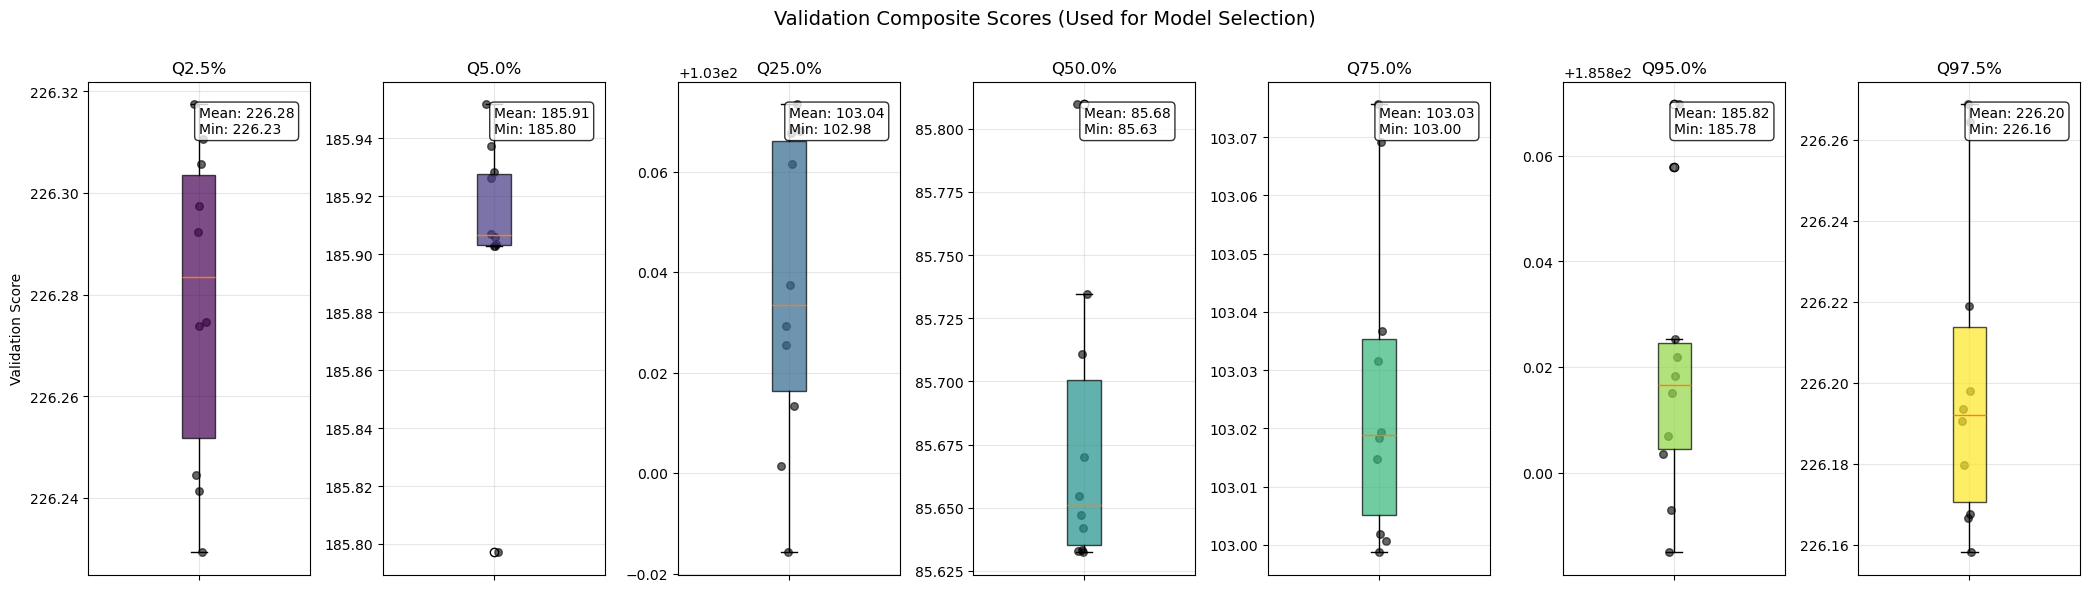

Note: These are VALIDATION scores used for model selection.


In [114]:

def plot_composite_score_boxplot_separate(all_training_results, quantiles):
    """
    Create separate boxplot for each quantile
    """
    n_quantiles = len(quantiles)
    fig, axes = plt.subplots(1, n_quantiles, figsize=(3*n_quantiles, 6))
    
    if n_quantiles == 1:
        axes = [axes]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    
    for i, tau in enumerate(quantiles):
        scores = [result['score'] for result in all_training_results[tau]]
        
        box_plot = axes[i].boxplot([scores], patch_artist=True)
        box_plot['boxes'][0].set_facecolor(colors[i])
        box_plot['boxes'][0].set_alpha(0.7)
        
        # Add individual points
        x_pos = np.random.normal(1, 0.02, len(scores))
        axes[i].scatter(x_pos, scores, alpha=0.6, s=30, color='black')
        
        axes[i].set_title(f"Q{tau*100:.1f}%")
        axes[i].set_ylabel('Validation Score' if i == 0 else '')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticklabels([''])
        
        # Add statistics text
        axes[i].text(0.5, 0.95, f'Mean: {np.mean(scores):.2f}\nMin: {np.min(scores):.2f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Validation Composite Scores (Used for Model Selection)', fontsize=14)
    plt.tight_layout()
    plt.savefig('composite_scores_separate_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Note: These are VALIDATION scores used for model selection.")

# Usage:
plot_composite_score_boxplot_separate(all_training_results, quantiles)

the composite score is lower the better for each quantile, and we did 10 times repeated models for each quantile, calcualte the composite score for each of the model and choose the one with lowest score.

#### 1. Coverage Error (30% weight)
Measures how close the actual coverage is to the target quantile.
- Example: 75% quantile should capture 75% of values
- If model captures 72%, coverage error = |72% - 75%| = 3%
- Lower is better

#### 2. Coverage Ratio (20% weight)
Measures the relative performance of coverage compared to target.
- Example: 75% quantile captures 72%, coverage ratio = 72% / 75% = 0.96
- Perfect ratio = 1.0, penalty = |ratio - 1.0|
- Complements coverage error by focusing on proportional accuracy
- Lower penalty is better

#### 3. Test Loss (25% weight)  
The standard quantile regression loss function.
- Penalises over-predictions and under-predictions differently
- For high quantiles, under-predicting is penalised more heavily
- Lower is better

#### 4. Validation Loss (15% weight)
Measures performance on unseen validation data.
- Indicates how well the model generalises
- Normalised by data scale for fair comparison
- Lower is better

#### 5. Calibration Score (10% weight)
Checks if the prediction spread matches the actual data spread.
- Prevents overly conservative or aggressive uncertainty estimates
- Compares the standard deviation of predictions vs actual values
- Ensures realistic uncertainty bounds
- Lower is better